# Introduction to NLP fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences of text or speech).

Another common term for NLP problem is sequence to sequence problems (seq2seq).

## Check for GPU

In [1]:
!nvidia-smi
!nvidia-smi -L

Tue Jul 12 17:30:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get helper functions

In [2]:
import os
if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-07-12 17:30:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-12 17:30:54 (90.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

See the original source: https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners/notebook

In [3]:
if not os.path.exists("nlp_getting_started.zip"):
    !wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data("nlp_getting_started.zip")

--2022-07-12 17:30:57--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-07-12 17:30:57 (140 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in , one way to do so would be to use Python: https://realpython.com/read-write-files-python/ 

But i prefer to get visual straight away.

So another way to do this is to use pandes...

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][1], train_df["target"][1]

('Forest fire near La Ronge Sask. Canada', 1)

In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


# What does the test dataframe look like?
test_df.head()

In [7]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # Create random indexes not higher than the total number
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text: {text}\n")

Target: 0 (not real disaster)
Text: Hey @reddit - the concept of a 'quarantine' makes no sense if the people you've quarantined can just wander out &amp; about whenever they want

Target: 1 (real disaster)
Text: Richard returns after whirlwind few days http://t.co/L8W30WFW3R #MLB

Target: 0 (not real disaster)
Text: Drop it down on a nigga do damage ! ??

Target: 0 (not real disaster)
Text: GREAT PERFORMANCE CHIP FUEL/GAS SAVER CHEVY TAHOE/BLAZER/AVALANCHE/S-10 http://t.co/iCrZi5TqC5 http://t.co/ONxhKfHn2a

Target: 1 (real disaster)
Text: $1 million bail for man accused of #shooting at Fife #police - Aug 5 @ 8:16 PM ET http://t.co/hu5CXqnoBf



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Use train_test_split to split training data into training and validation sets 
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=0.1,
    random_state=42)

In [12]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Cnverting text into numbers

When dealing with a text problem, one of the first thing you'll have to do before you can build a model is to convert your text to numbers. 

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character)
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [14]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [15]:
train_sentences[0].split(), len(train_sentences[0].split())

(['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet'], 7)

In [16]:
# Find the average number of tokes (words) in the training tweets
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_length

15

In [17]:
max_vocab_length = 10000

In [18]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    standardize="lower_and_strip_punctuation", # Default
    split="whitespace", # Default
    ngrams=None, # Default
    output_mode="int",
    output_sequence_length=max_length,
    pad_to_max_tokens=True) # Default

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n\
    Vectorized version:")
text_vectorizer([random_sentence])

Original text:
someone: mentions gansey on fire
me busting through the brick walls of seven different buildings:
    Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 475, 2050,    1,   11,   42,   31,    1,  295,    2, 6067, 3266,
           6, 1766, 1215,   95]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
len(words_in_vocab), top_5_words, bottom_5_words

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'])

### Creating an Embedding using an EmbeddingLayer

To make our embedding, we're going to use TensorFlow's EmbeddingLayer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer: 
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each tolen gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer 

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    input_length=max_length)
embedding

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
    \nEmbedded version: ")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
I'm blazing rn and there's nothing you can do to stop me    
Embedded version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00425172, -0.00160626,  0.04125797, ...,  0.04907576,
         -0.0492836 ,  0.03941442],
        [-0.01453899,  0.01424965,  0.04314465, ..., -0.03449648,
         -0.03461619, -0.03398571],
        [-0.03533477, -0.01348163, -0.02819748, ...,  0.04613021,
          0.01992854,  0.01977536],
        ...,
        [ 0.02844235,  0.0420007 ,  0.01215855, ...,  0.04604912,
         -0.04193454, -0.01709964],
        [ 0.02844235,  0.0420007 ,  0.01215855, ...,  0.04604912,
         -0.04193454, -0.01709964],
        [ 0.02844235,  0.0420007 ,  0.01215855, ...,  0.04604912,
         -0.04193454, -0.01709964]]], dtype=float32)>

In [25]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.00425172, -0.00160626,  0.04125797,  0.03486824,  0.01498418,
         0.0433372 , -0.02469661, -0.00189818, -0.0461166 , -0.00568752,
        -0.03959838,  0.04108726,  0.0079518 ,  0.04052121,  0.01705294,
         0.04713902,  0.04296252, -0.02821313, -0.01232759,  0.03136191,
         0.04485169,  0.03453543,  0.01575087, -0.03765459, -0.02403343,
         0.02758572,  0.03888771,  0.03303099, -0.00925253, -0.03453044,
        -0.0203127 ,  0.02579116,  0.03802747,  0.01484679, -0.04828334,
         0.0019739 ,  0.03652677,  0.04401236, -0.00185243,  0.01661864,
         0.0118281 , -0.02053506,  0.01304623,  0.03513253, -0.00610243,
        -0.04043629, -0.03465058,  0.01797668,  0.01120793, -0.01455634,
        -0.00712692,  0.01271221,  0.04122372,  0.01814631, -0.03977837,
         0.04575198, -0.02028467,  0.04534203,  0.03745409,  0.01058296,
        -0.01141857, -0.0082926 ,  0.00615988, -0.03408819,  0.04044152,
  

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time  to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), from sklearn ML map: 
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM (RNN)
* Model 3: GRU (RNN) 
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:
* Create a model
* Build the model
* Fit the model
* Evaluate the model

### Model 0: Getting a baseline

As with all machine learning modelling experiments it's important to create a baseline model so you've got a benchmark for future experiments to build uopn.

To create our baseline, we'll use Sklearn's Mulinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑 **Note:** It's common to use non DL-algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([ # Pipeline is similar to tensorflow's sequential
    ("tfidf", TfidfVectorizer()), # name of the step is "tfidf"; convert words to numbers using tfidf
    ("clf", MultinomialNB()), # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [29]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however this will be cumbersome and could easily be fixed with a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different methods, see the Sklearn documentation.

In [30]:
# Function to evaluate accuracy, precision, reall and f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binare classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _, = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_accuracy, 
        "precision": model_precision,
        "recall": model_recall, 
        "f1-score": model_f1}
    return model_results

In [31]:
# Get baseline results
baseline_results = calculate_results(
    y_true=val_labels,
    y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1-score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [32]:
# Create a tensorboard callback (Need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [34]:
# Compile model
model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

In [35]:
# Fit the model
model_1_history = model_1.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_1_dense"
    )]
)

Saving TensorBoard log files to: model_logs/model_1_dense/20220712-173105
Epoch 1/5
215/215 [==============================] - 9s 9ms/step - loss: 0.6100 - accuracy: 0.6930 - val_loss: 0.5358 - val_accuracy: 0.7493
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4398 - accuracy: 0.8184 - val_loss: 0.4667 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3457 - accuracy: 0.8616 - val_loss: 0.4588 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2839 - accuracy: 0.8911 - val_loss: 0.4656 - val_accuracy: 0.7966
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2361 - accuracy: 0.9153 - val_loss: 0.4790 - val_accuracy: 0.7887


In [36]:
baseline_results,

({'accuracy': 79.26509186351706,
  'f1-score': 0.7862189758049549,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706},)

In [37]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4790 - accuracy: 0.7887


[0.47895973920822144, 0.7887139320373535]

In [38]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs

array([[3.88021499e-01],
       [8.13324213e-01],
       [9.98109937e-01],
       [1.07442297e-01],
       [1.17617287e-01],
       [9.35801506e-01],
       [9.20977533e-01],
       [9.93130982e-01],
       [9.70727563e-01],
       [2.30573520e-01],
       [1.05123185e-01],
       [6.79786026e-01],
       [5.30182235e-02],
       [1.85088232e-01],
       [4.95905569e-03],
       [1.23898461e-01],
       [2.77216136e-02],
       [7.65865073e-02],
       [2.05416173e-01],
       [5.10562837e-01],
       [9.15307343e-01],
       [4.28515710e-02],
       [4.27625686e-01],
       [7.20809475e-02],
       [9.59228992e-01],
       [9.98811841e-01],
       [2.68224906e-02],
       [7.08449632e-02],
       [2.51108855e-02],
       [1.97951138e-01],
       [5.41886568e-01],
       [2.31611699e-01],
       [4.82257783e-01],
       [1.99650854e-01],
       [5.25000751e-01],
       [5.21190166e-02],
       [9.94018793e-01],
       [1.32729843e-01],
       [2.90919002e-02],
       [9.98669267e-01],


In [39]:
# Look at a single prediction
model_1_pred_probs[0]

array([0.3880215], dtype=float32)

In [40]:
# Look at the first 10
model_1_pred_probs[:10]

array([[0.3880215 ],
       [0.8133242 ],
       [0.99810994],
       [0.1074423 ],
       [0.11761729],
       [0.9358015 ],
       [0.92097753],
       [0.993131  ],
       [0.97072756],
       [0.23057352]], dtype=float32)

In [41]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [42]:
# Calculate our model_1 results
model_1_results = calculate_results(
    y_true=val_labels,
    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'f1-score': 0.7856693843184869,
 'precision': 0.7939119079827037,
 'recall': 0.7887139107611548}

In [43]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1-score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [44]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings


In [45]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [46]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [47]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights)
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

[[ 0.0472912   0.02413734  0.00377305 ...  0.06508201 -0.06026678
   0.00142188]
 [ 0.00049827 -0.00648262  0.04461583 ...  0.0174851   0.01777712
   0.05278213]
 [ 0.02184566 -0.04668173  0.00077051 ... -0.02330029  0.00151436
   0.04540404]
 ...
 [ 0.03678239 -0.01421575  0.04732505 ... -0.028166   -0.00810652
   0.00948545]
 [ 0.02113183 -0.04389714 -0.02218872 ...  0.04749653 -0.04162758
  -0.00803098]
 [ 0.02291374 -0.11444009 -0.07562084 ...  0.11021747 -0.04070343
   0.11256574]]
(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [48]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


Downloading the files above we can visualize them using http://projector.tensorflow.org/ and clicking the "load" button on  the left hand side.

> 📖 **Ressource:** If you'd like to know more about embeddings, I'd encourage you to check out:
* Jay Alammar's visualized word2vec post: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embeddings guide: https://www.tensorflow.org/tutorials/text/word_embeddings

## Recurrent Neural Networks (RNNs)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> 📖 **Ressources:** If you want an overview of the internals of a recurrent neural network, see the following:
 - MIT's sequence modell lecture: https://youtu.be/qjrad0V0uJE
 - Chris Olag's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
 - Andrej Kaparthy's the unreasonable effectiveness of recurrent neural networks: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM
LSTM  = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:
```Input(text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)```

In [49]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1, ), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [50]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [51]:
# Compile the nmodel
model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [52]:
# Fit
histor_model_2 = model_2.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220712-173129
Epoch 1/5
215/215 [==============================] - 6s 8ms/step - loss: 0.2218 - accuracy: 0.9213 - val_loss: 0.6937 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1569 - accuracy: 0.9432 - val_loss: 0.6892 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1269 - accuracy: 0.9508 - val_loss: 0.7855 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1043 - accuracy: 0.9575 - val_loss: 1.0425 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0828 - accuracy: 0.9654 - val_loss: 1.1560 - val_accuracy: 0.7638


In [53]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[1.9378250e-02],
       [6.2073839e-01],
       [9.9991190e-01],
       [2.8189393e-03],
       [7.3383977e-05],
       [9.9942809e-01],
       [9.6393979e-01],
       [9.9997354e-01],
       [9.9991202e-01],
       [7.6508707e-01]], dtype=float32)

In [54]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [55]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [56]:
# Calculate model 2 results
model_2_results = calculate_results(
    y_true=val_labels,
    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.37795275590551,
 'f1-score': 0.761768588939328,
 'precision': 0.7649838845988884,
 'recall': 0.7637795275590551}

In [57]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1-score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

> 📖 **Ressource:** 
 - https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be
 - https://en.wikipedia.org/wiki/Gated_recurrent_unit

In [58]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True)(x) # if you wand to stack recurrent layers --> return_sequences = True
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [59]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                       

In [60]:
# Compile the model
model_3.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

In [61]:
# Fit 
model_3_history = model_3.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220712-173142
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1552 - accuracy: 0.9406 - val_loss: 0.7885 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0809 - accuracy: 0.9701 - val_loss: 0.9247 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0655 - accuracy: 0.9740 - val_loss: 1.0065 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0551 - accuracy: 0.9769 - val_loss: 1.2358 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0511 - accuracy: 0.9759 - val_loss: 1.3106 - val_accuracy: 0.7690


In [62]:
# Make predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[6.4210291e-03],
       [4.4472975e-01],
       [9.9998808e-01],
       [2.9606831e-01],
       [1.0718668e-05],
       [9.9979764e-01],
       [1.3051219e-01],
       [9.9999058e-01],
       [9.9997520e-01],
       [7.9509383e-01]], dtype=float32)

In [63]:
# Convert pred_probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [64]:
# Calculate model 3 results
model_3_results = calculate_results(
    y_true=val_labels,
    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.9028871391076,
 'f1-score': 0.7660901868079131,
 'precision': 0.772410916855732,
 'recall': 0.7690288713910761}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence), however a bidirectional RNN goes from right to left as well as left to right.

> 📖 **Ressources:** 
 - https://easy-tensorflow.com/tf-tutorials/recurrent-neural-networks/bidirectional-rnn-for-classification

In [65]:
# Build a bidirectional RNN (BRNN)
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_BRNN")

In [66]:
model_4.summary()

Model: "model_4_BRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
No

In [67]:
model_4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "model_4_BRNN")])

Saving TensorBoard log files to: model_logs/model_4_BRNN/20220712-173151
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.1118 - accuracy: 0.9626 - val_loss: 1.1073 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0500 - accuracy: 0.9793 - val_loss: 1.2874 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0484 - accuracy: 0.9793 - val_loss: 1.2297 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0427 - accuracy: 0.9801 - val_loss: 1.4414 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0417 - accuracy: 0.9803 - val_loss: 1.3258 - val_accuracy: 0.7677


In [68]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[1.8069221e-01],
       [9.7826147e-01],
       [9.9996758e-01],
       [2.3242012e-01],
       [2.9510060e-05],
       [9.9980706e-01],
       [9.2942119e-01],
       [9.9997616e-01],
       [9.9996483e-01],
       [8.5806286e-01]], dtype=float32)

In [69]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [70]:
model_4_results = calculate_results(
    y_true=val_labels,
    y_pred=model_4_preds
)
model_4_results

{'accuracy': 76.77165354330708,
 'f1-score': 0.7662770891654436,
 'precision': 0.7681410880728078,
 'recall': 0.7677165354330708}

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however our textdata is 1D.

Previously we've used Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):
```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)
* Difference between same and valid padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t


In [71]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["This a test sentence"])) # turn target sequence into an embedding
conv_1d = layers.Conv1D(
    filters=32,
    kernel_size=5,
    activation="relu",
    padding="same"
)
conv_1d_output = conv_1d(embedding_test) #6 pass test embedding through our Conv1D layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [72]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.05846079, -0.00607412,  0.04632553, ...,  0.07662604,
         -0.04180934,  0.02042088],
        [ 0.02659065,  0.00033405,  0.0111361 , ...,  0.02466691,
         -0.07765971,  0.02062846],
        [-0.00510978, -0.01981938, -0.12607175, ..., -0.03898013,
          0.04852548,  0.01195497],
        ...,
        [ 0.02273669,  0.0083076 ,  0.01255527, ...,  0.04086352,
         -0.0547768 ,  0.00077887],
        [ 0.02273669,  0.0083076 ,  0.01255527, ...,  0.04086352,
         -0.0547768 ,  0.00077887],
        [ 0.02273669,  0.0083076 ,  0.01255527, ...,  0.04086352,
         -0.0547768 ,  0.00077887]]], dtype=float32)>

In [73]:
conv_1d_output

<tf.Tensor: shape=(1, 15, 32), dtype=float32, numpy=
array([[[0.00000000e+00, 0.00000000e+00, 4.57468107e-02, 0.00000000e+00,
         3.81535292e-02, 7.63439387e-02, 1.96403936e-02, 0.00000000e+00,
         2.52681226e-02, 0.00000000e+00, 5.21171056e-02, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 4.37481478e-02, 1.53670553e-02,
         6.98568672e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.51482323e-03,
         0.00000000e+00, 0.00000000e+00, 3.16073969e-02, 3.44706960e-02],
        [0.00000000e+00, 0.00000000e+00, 6.08274993e-03, 7.00572506e-02,
         0.00000000e+00, 2.54937634e-03, 2.73008477e-02, 0.00000000e+00,
         1.45382888e-03, 0.00000000e+00, 0.00000000e+00, 1.37964264e-02,
         7.39113539e-02, 1.47348521e-02, 3.41558158e-02, 0.00000000e+00,
         3.43557298e-02, 2.08353885e-02, 0.00000000e+00, 0.00000000e+0

In [74]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.01850078, 0.01501693, 0.04574681, 0.10466886, 0.03815353,
        0.07634394, 0.05310717, 0.02739397, 0.08711036, 0.00487614,
        0.05544959, 0.01379643, 0.07391135, 0.08256259, 0.04802284,
        0.05527403, 0.14385727, 0.1182954 , 0.        , 0.08063742,
        0.03168627, 0.09230812, 0.        , 0.05614208, 0.02998058,
        0.01643194, 0.05782744, 0.00751482, 0.04956149, 0.16797431,
        0.0316074 , 0.04981643]], dtype=float32)>

In [75]:
# Create 1-d convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(
    filters=64, 
    kernel_size=5, # each filter is looking at 5 words at a time
    strides=1,
    activation="relu",
    padding="valid",
)(x)
x = layers.GlobalMaxPool1D()(x)
# x =layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")


In [76]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1)              

In [77]:
model_5.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [78]:
model_5.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "model_5_Conv1D"
    )]
)

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20220712-173211
Epoch 1/5
215/215 [==============================] - 4s 9ms/step - loss: 0.1273 - accuracy: 0.9565 - val_loss: 0.9076 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0758 - accuracy: 0.9727 - val_loss: 1.0593 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0624 - accuracy: 0.9749 - val_loss: 1.1446 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0537 - accuracy: 0.9777 - val_loss: 1.1921 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0537 - accuracy: 0.9783 - val_loss: 1.1905 - val_accuracy: 0.7598


In [79]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[4.5639026e-01],
       [9.4488043e-01],
       [9.9996912e-01],
       [9.3256667e-02],
       [1.1717701e-06],
       [9.9941373e-01],
       [9.7977358e-01],
       [9.9998367e-01],
       [9.9999964e-01],
       [8.8437963e-01]], dtype=float32)

In [80]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [81]:
model_5_results = calculate_results(
    y_true=val_labels,
    y_pred=model_5_preds
)
model_5_results

{'accuracy': 75.98425196850394,
 'f1-score': 0.7590768821741806,
 'precision': 0.7594780880165999,
 'recall': 0.7598425196850394}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've build a few of our own model, let's try and use transfer leraning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder.

In [82]:
sample_sentence

"There's a flood in my street"

In [83]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [84]:
# Create a Keras Layer using the USW pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="USE"
)

In [85]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer"),
], name="model_6_USE")

In [86]:
# Compile the model
model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [87]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [88]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "tf_hub_sentence_encoder"
    )]
)

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220712-173252
Epoch 1/5
215/215 [==============================] - 5s 13ms/step - loss: 0.4983 - accuracy: 0.7860 - val_loss: 0.4529 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.4140 - accuracy: 0.8159 - val_loss: 0.4384 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3992 - accuracy: 0.8208 - val_loss: 0.4339 - val_accuracy: 0.8058
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3916 - accuracy: 0.8260 - val_loss: 0.4262 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3844 - accuracy: 0.8281 - val_loss: 0.4270 - val_accuracy: 0.8163


In [89]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences),
model_6_pred_probs[:5]

(array([[0.16951914],
        [0.7882122 ],
        [0.9876496 ],
        [0.22316977],
        [0.76107866],
        [0.75656146],
        [0.9848316 ],
        [0.98289216],
        [0.946928  ],
        [0.11135335],
        [0.58240193],
        [0.39691114],
        [0.17597948],
        [0.55589414],
        [0.24490215],
        [0.02629266],
        [0.40498173],
        [0.59943515],
        [0.3923854 ],
        [0.33303285],
        [0.9167108 ],
        [0.16570489],
        [0.5204492 ],
        [0.03506904],
        [0.92163324],
        [0.9659887 ],
        [0.06505248],
        [0.10431332],
        [0.1307779 ],
        [0.38788664],
        [0.4940648 ],
        [0.93513125],
        [0.41323656],
        [0.28585902],
        [0.56600404],
        [0.10511889],
        [0.97666943],
        [0.06506552],
        [0.04365131],
        [0.9821346 ],
        [0.0763255 ],
        [0.24968474],
        [0.39799842],
        [0.5057665 ],
        [0.2576215 ],
        [0

In [90]:
# Convert pred probs to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [91]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(
    y_true=val_labels,
    y_pred=model_6_preds
)
print(f"Model 6 USE:\n{model_6_results}\nBaseline:\n{baseline_results}")

Model 6 USE:
{'accuracy': 81.62729658792651, 'precision': 0.8170007401548035, 'recall': 0.8162729658792651, 'f1-score': 0.8153469807013113}
Baseline:
{'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1-score': 0.7862189758049549}


In [92]:
len(train_sentences), len(train_df), len(train_df_shuffled)

(6851, 7613, 7613)

## Model 7: TF Hub Pretrained USE but with 10% training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

> ⚠️ **Note:** Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained 100% data). DO NOT make data splits which leak data from validation/test set into training set.

In [93]:
# THIS IS BAD!
# Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_10_percent.head(), len(train_10_percent)

> 🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data accross the dataset. Otherwise your model evaluation metrics will be wrong. If something looks to good to be true (a model trained on 10% of data outperforming the same model trained 100% of data) trust your gut and go back through to find where the error may lie.

In [94]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences)) # already in random order
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [95]:
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [96]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [97]:
# Check the number of target in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model we've created, we can use the `tf.keras.models.clone_model()` method.

In [98]:
# Let's build a model the same as model 6
model_7 = tf.keras.models.clone_model(model_6)

In [99]:
# Compile
model_7.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [100]:
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [101]:
model_7.fit(
    train_sentences_10_percent,
    train_labels_10_percent,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "model_7_USE_10_percent_correct_split"
    )]
)

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent_correct_split/20220712-173311
Epoch 1/5
22/22 [==============================] - 3s 40ms/step - loss: 0.6692 - accuracy: 0.6920 - val_loss: 0.6445 - val_accuracy: 0.7428
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5952 - accuracy: 0.8029 - val_loss: 0.5859 - val_accuracy: 0.7572
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5197 - accuracy: 0.8204 - val_loss: 0.5315 - val_accuracy: 0.7743
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4609 - accuracy: 0.8248 - val_loss: 0.4998 - val_accuracy: 0.7808
Epoch 5/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4203 - accuracy: 0.8380 - val_loss: 0.4881 - val_accuracy: 0.7822


In [102]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.21784952],
       [0.587639  ],
       [0.9285175 ],
       [0.36888686],
       [0.5356703 ],
       [0.68968004],
       [0.902588  ],
       [0.8293751 ],
       [0.8239721 ],
       [0.14327493]], dtype=float32)

In [103]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [104]:
model_7_results = calculate_results(
    y_true=val_labels,
    y_pred=model_7_preds
)
model_7_results

{'accuracy': 78.21522309711287,
 'f1-score': 0.7805300645444495,
 'precision': 0.7833242410577732,
 'recall': 0.7821522309711286}

In [105]:
model_6_results

{'accuracy': 81.62729658792651,
 'f1-score': 0.8153469807013113,
 'precision': 0.8170007401548035,
 'recall': 0.8162729658792651}

In [106]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1-score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Compare the performance of each of our models

In [107]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "1_simple_dense": model_1_results,
    "2_LSTM": model_2_results,
    "3_GRU": model_3_results,
    "4_bidirectional": model_4_results,
    "5_conv1D": model_5_results,
    "6_tf_hub_USE": model_6_results,
    "7_tf_hub_USE_10_perc": model_7_results    
})
all_model_results = all_model_results.transpose()

In [108]:
# Reduce the accuracyas the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1-score
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.788714,0.793912,0.788714,0.785669
2_LSTM,0.763780,0.764984,0.763780,0.761769
3_GRU,0.769029,0.772411,0.769029,0.766090
4_bidirectional,0.767717,0.768141,0.767717,0.766277
5_conv1D,0.759843,0.759478,0.759843,0.759077
6_tf_hub_USE,0.816273,0.817001,0.816273,0.815347
7_tf_hub_USE_10_perc,0.782152,0.783324,0.782152,0.780530


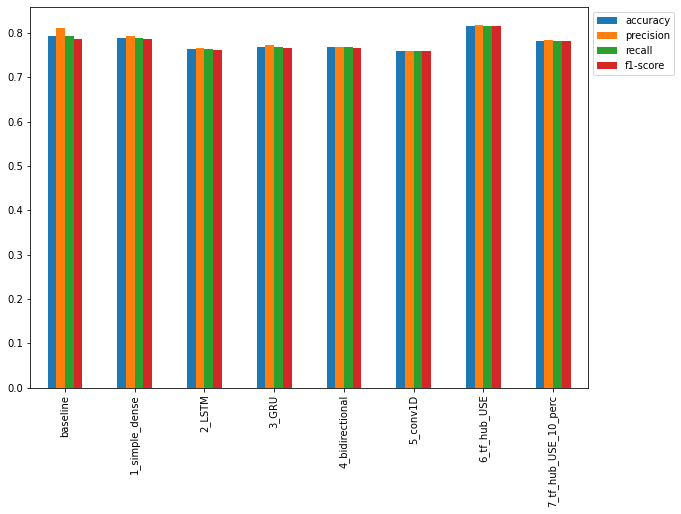

In [109]:
# Plot and compare all of the model results
all_model_results.plot(
    kind="bar", 
    figsize=(10,7)
).legend(bbox_to_anchor=(1.0, 1.0))


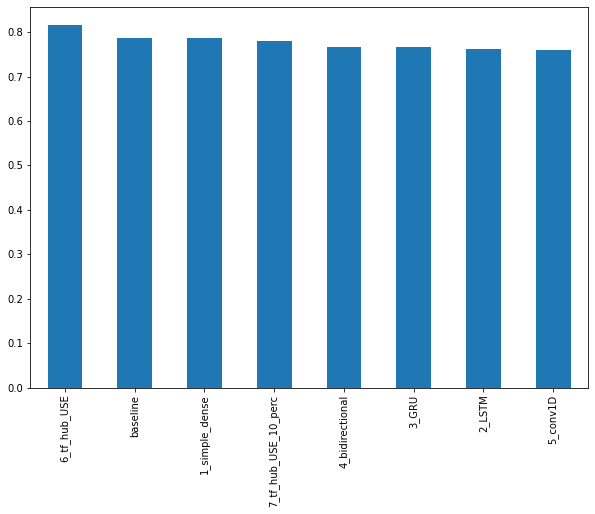

In [110]:
# Sort model results by f1-score
all_model_results.sort_values("f1-score", ascending=False)["f1-score"].plot(kind="bar", figsize=(10, 7))

## Uploading our model training logs to TensorBoard.dev

We can further inspect our model's performance using TensorBoard.dev: https://tensordboard.dev

In [111]:
#%reload_ext tensorboard
#!tensorboard --logdir ./model_logs/

http://localhost:6006/

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. HDF5 format
2. `SavedModel` format (this is the default when using TensorFlow)

In [112]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save('model_6.h5')

> 🔑 **Note:** If loading doesn't work because of OOM, restart kernel and start from here. You also need to import the data again (above).

In [115]:
# Load model with custom Hab Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model(
    "model_6.h5",
    custom_objects={"KerasLayer": hub.KerasLayer}
)

In [116]:
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets
